# Strategy for monthly return(short-term investment)

Objective: We will code a strategy and then compare the strategy return with index return. For comparision we will code some KPIs(key performance indicators) to measure risk and return when compared with index price.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 100)

In [3]:
# DJI constituent stocks
tickers = ["MMM", "AXP", "T", "BA", "CAT", "CVX", "CSCO", "KO", "XOM", "GE", "GS", "HD",
           "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PFE", "PG", "TRV",
           "UTX", "UNH", "VZ", "V", "WMT", "DIS"]

In [4]:
# directory with open, high, low, close(ohlc) value for each stock
ohlc_mon = {}  

In [5]:
# start and end date of historical data (monthly) to be extracted 
start = dt.datetime.today() - dt.timedelta(3650)
end = dt.datetime.today()

In [ ]:
# looping over tickers and creating a dataframe
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker, start, end, interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True, how="all")

In [7]:
# redefine tickers variable after removing any tickers with corrupted data
tickers = ohlc_mon.keys()

In [8]:
# function to calculate the Cumulative Annual Growth Rate of a trading strategy
def CAGR(DF):
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df) / 12
    CAGR = (df["cum_return"].tolist()[-1]) ** (1 / n) - 1
    return CAGR

In [9]:
# function to calculate annualized volatility of a trading strategy
def volatility(DF):
    df = DF.copy()
    vol: object = df["mon_ret"].std() * np.sqrt(12)
    return vol

In [10]:
# function to calculate sharpe ratio ; rf is the risk free rate
def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf) / volatility(df)
    return sr

In [11]:
# function to calculate max drawdown
def max_dd(DF):
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"] / df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [12]:
# keeping the data safe
ohlc_dict = copy.deepcopy(ohlc_mon)

In [ ]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ", ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]

In [14]:
# function to calculate portfolio return iteratively
def pflio(DF, m, x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(1, len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i, :].mean())
            bad_stocks = df[portfolio].iloc[i, :].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
#        new_picks = df[[t for t in tickers if t not in portfolio]].iloc[i, :].sort_values(ascending=False)\
#                        [:fill].index.values.tolist() # for no repetition of stocks in portfolio
        new_picks = df.iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["mon_ret"])
    return monthly_ret_df

In [15]:
# calculating overall strategy's KPIs
print(CAGR(pflio(return_df, 6, 3)))
print(sharpe(pflio(return_df, 6, 3), 0.025))
print(max_dd(pflio(return_df, 6, 3)))

0.14060505590973404
0.9205807891437143
0.21917603206768513


In [16]:
# calculating KPIs for Index buy and hold strategy over the same period
DJI = yf.download("^DJI", start, end, interval='1mo')
DJI["mon_ret"] = DJI["Adj Close"].pct_change()
print(CAGR(DJI))
print(sharpe(DJI, 0.025))
print(max_dd(DJI))

[*********************100%***********************]  1 of 1 completed
0.0964385575779314
0.5465699635477885
0.23201266165063414


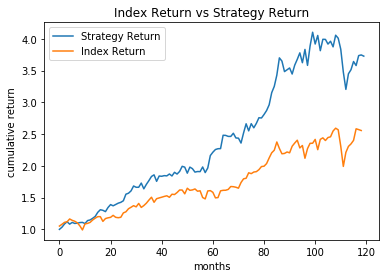

In [17]:
# visualization
fig, ax = plt.subplots()
plt.plot((1 + pflio(return_df, 6, 3)).cumprod())
plt.plot((1 + DJI["mon_ret"][2:].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return", "Index Return"])